# 6.3 Advanced RNN
1. Dropout
2. Stacking
3. Bidirectional RNN

In [1]:
import os

data_dir = 'C:/Users/Gene/Desktop/projects/keras_tutorial/datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

del data

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [3]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

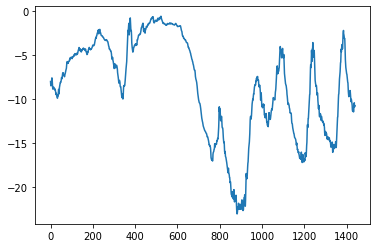

In [4]:
plt.plot(range(1440), temp[:1440])

In [5]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets =next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2908822379857457


In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 1.3872 - val_loss: 0.7577
Epoch 2/20
500/500 [==============================] - 12s 23ms/step - loss: 0.5417 - val_loss: 0.3230
Epoch 3/20
500/500 [==============================] - 13s 25ms/step - loss: 0.3109 - val_loss: 0.3083
Epoch 4/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2735 - val_loss: 0.3025
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2571 - val_loss: 0.3110
Epoch 6/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2475 - val_loss: 0.3459
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2407 - val_loss: 0.3199
Epoch 8/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2321 - val_loss: 0.3160
Epoch 9/20
500/500 [==============================] - 12s 23ms/s

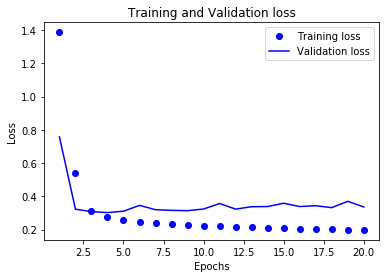

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
#for more lager gpu memory use
'''import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
session = tf.Session(config=config)
K.set_session(session)'''

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, recurrent_dropout=0.2, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.figure()

plt.plot(epochs, loss, 'bo', label = "Training loss")
plt.plot(epochs, val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequence=True, input_shape = (None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential
import numpy as np
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 219s 11ms/step - loss: 0.5468 - acc: 0.7239 - val_loss: 0.4373 - val_acc: 0.8248
Epoch 2/10
20000/20000 [==============================] - 238s 12ms/step - loss: 0.3269 - acc: 0.8737 - val_loss: 0.2920 - val_acc: 0.8884
Epoch 3/10
20000/20000 [==============================] - 236s 12ms/step - loss: 0.2610 - acc: 0.9034 - val_loss: 0.3275 - val_acc: 0.8804
Epoch 4/10
20000/20000 [==============================] - 222s 11ms/step - loss: 0.2274 - acc: 0.9183 - val_loss: 0.5728 - val_acc: 0.8296
Epoch 5/10
20000/20000 [==============================] - 206s 10ms/step - loss: 0.2016 - acc: 0.9293 - val_loss: 0.4286 - val_acc: 0.8572
Epoch 6/10
20000/20000 [==============================] - 208s 10ms/step - loss: 0.1833 - acc: 0.9357 - val_loss: 0.3746 - val_acc: 0.85

In [ ]:
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compil(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)